In [1]:
!pip install kaggle
!pip install --upgrade seaborn matplotlib pandas
!pip install python-multipart
!pip install fastapi uvicorn torch torchvision pillow

In [17]:
from fastapi import FastAPI, File, UploadFile
from torchvision import transforms
from PIL import Image
from pydantic import BaseModel
import nest_asyncio
from PIL import Image
from torchvision import transforms
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

C:\Users\Lenovo\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Lenovo\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
import torch.nn as nn  # ✅ Fix: Import nn module
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import time
from sklearn.utils.class_weight import compute_class_weight  # ✅ Import this!

In [4]:
import torch
import uvicorn
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from fastapi import FastAPI, File, UploadFile
from torchvision import transforms
from PIL import Image
from pydantic import BaseModel
import nest_asyncio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from sklearn.utils.class_weight import compute_class_weight

In [5]:
import shutil
shutil.move("kaggle.json", "kaggle.json")

'kaggle.json'

In [6]:
!kaggle datasets download -d abhranta/brain-tumor-detection-mri

Dataset URL: https://www.kaggle.com/datasets/abhranta/brain-tumor-detection-mri
License(s): unknown
brain-tumor-detection-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
import os

# Define the path of the downloaded dataset
zip_file = "brain-tumor-detection-mri.zip"  # Ensure this matches your downloaded file

# Extract the contents
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_dataset")  # Extract to a folder

print("Extraction complete!")


Extraction complete!


In [8]:
import os

# Check extracted folder contents
extracted_path = "brain_tumor_dataset"
print("Extracted files and folders:", os.listdir(extracted_path))


Extracted files and folders: ['Brain_Tumor_Detection']


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Correct the dataset directory path
dataset_dir = r'C:\Users\Lenovo\Desktop\project\brain_tumor_dataset\Brain_Tumor_Detection'

# Ensure the subfolders 'yes' and 'no' exist under this directory
categories = ['yes', 'no']
image_paths = []
labels = []

# Load image paths and labels
for category in categories:
    category_path = os.path.join(dataset_dir, category)
    if os.path.exists(category_path):  # Check if the path exists
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            image_paths.append(img_path)
            labels.append(1 if category == 'yes' else 0)
    else:
        print(f"Warning: Folder '{category}' does not exist at {category_path}")


# Define transforms (data augmentation for training, and normalization for both train and test)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet's normalization stats
])

# Load image paths and labels
for category in categories:
    category_path = os.path.join(dataset_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        image_paths.append(img_path)
        labels.append(1 if category == 'yes' else 0)

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create Datasets and DataLoaders
train_dataset = BrainTumorDataset(X_train, y_train, transform=transform)
test_dataset = BrainTumorDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [10]:
# Define the CNN model with dynamic flattening
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 18 * 18, 128)  # You need to adjust this size later based on the output size
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        
        # Dynamically calculate the flattened size of the output
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


# Initialize the model
model = CNNModel().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Train the model
num_epochs = 5
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs.view(-1), labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        predicted = (outputs.view(-1) > 0.5).float()  # Threshold at 0.5 for binary classification
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Store metrics
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    
    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            
            outputs = model(images)
            loss = criterion(outputs.view(-1), labels)
            
            test_loss += loss.item()
            
            predicted = (outputs.view(-1) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")


Epoch [1/5], Train Loss: 0.4252, Train Accuracy: 79.23%, Test Loss: 0.2871, Test Accuracy: 88.25%
Epoch [2/5], Train Loss: 0.1799, Train Accuracy: 93.12%, Test Loss: 0.1328, Test Accuracy: 94.67%
Epoch [3/5], Train Loss: 0.0790, Train Accuracy: 97.33%, Test Loss: 0.1029, Test Accuracy: 95.92%
Epoch [4/5], Train Loss: 0.0409, Train Accuracy: 98.65%, Test Loss: 0.0526, Test Accuracy: 98.08%
Epoch [5/5], Train Loss: 0.0213, Train Accuracy: 99.25%, Test Loss: 0.0240, Test Accuracy: 99.58%


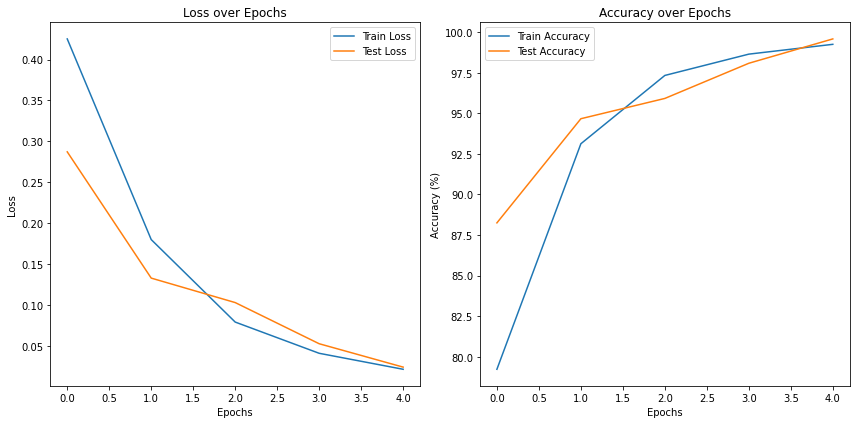

In [12]:
# Plot training and testing performance
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.plot(range(num_epochs), test_losses, label="Test Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label="Train Accuracy")
plt.plot(range(num_epochs), test_accuracies, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), "brain_tumor_detection_model.pth")

In [13]:
model = CNNModel()  # Instantiate your model architecture
model.load_state_dict(torch.load("brain_tumor_detection_model.pth"))
model.eval()  # Set the model to evaluation mode

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4732\3226644937.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("brain_tumor_detection_mode

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=41472, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

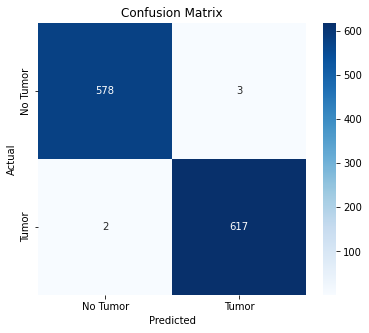

Classification Report:
              precision    recall  f1-score   support

    No Tumor       1.00      0.99      1.00       581
       Tumor       1.00      1.00      1.00       619

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Accuracy: 99.58%


In [18]:
# Evaluate the model on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0.0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        
        outputs = model(images)
        loss = criterion(outputs.view(-1), labels)
        
        test_loss += loss.item()
        
        # Get the predicted labels
        predicted = (outputs.view(-1) > 0.5).float()  # Threshold at 0.5 for binary classification
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        
        # Calculate accuracy (if needed)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate classification report (precision, recall, F1-score)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["No Tumor", "Tumor"]))

# Optionally, print accuracy separately
accuracy = (np.array(y_true) == np.array(y_pred)).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4732\1956890089.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("brain_tumor_detection_mod

Enter the path to the image for prediction: C:/Users/Lenovo/Pictures/Screenshots/Screenshot 2025-02-04 172814.png
No tumor detected with probability 0.9988


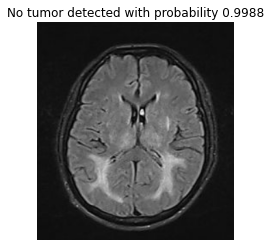

In [19]:
# Define the same transforms as used during training
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet's normalization stats
])

# Function to preprocess the input image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Open the image and convert it to RGB
    image = transform(image)  # Apply the transformations
    image = image.unsqueeze(0)  # Add a batch dimension (for batch processing)
    return image

# Define the CNN model (same as during training)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 18 * 18, 128)  # Adjust based on image size
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
model.load_state_dict(torch.load("brain_tumor_detection_model.pth"))
model.eval()  # Set the model to evaluation mode

# Function to make prediction
def predict_image(image_path):
    image = preprocess_image(image_path)  # Preprocess the image
    image = image.to(device)  # Move the image to the GPU if available

    # Get the model's prediction
    with torch.no_grad():  # Disable gradient calculation (we are not training)
        output = model(image)  # Forward pass through the model
        probability = output.item()  # Get the probability (between 0 and 1)
        prediction = (output > 0.5).float()  # Convert output to binary (0 or 1)
        
    if prediction.item() == 1:
        return f"Tumor detected with probability {probability:.4f}"
    else:
        return f"No tumor detected with probability {1 - probability:.4f}"

# Input image path (from the user)
image_path = input("Enter the path to the image for prediction: ")
result = predict_image(image_path)  # Get prediction
print(result)  # Output the result

# Display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title(result)  # Display prediction result
plt.show()


In [35]:
class CNNModelWithDropout(nn.Module):
    def __init__(self):
        super(CNNModelWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Dropout during inference
        
        self.fc1 = nn.Linear(128 * 18 * 18, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)  # Apply dropout after conv1
        
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)  # Apply dropout after conv2
        
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout(x)  # Apply dropout after conv3
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(torch.relu(self.fc1(x)))  # Apply dropout after fc1
        x = self.sigmoid(self.fc2(x))
        return x

# Load trained weights into the Dropout model
dropout_model = CNNModelWithDropout().to(device)
dropout_model.load_state_dict(torch.load("brain_tumor_detection_model.pth"))
print("Pre-trained CNN weights loaded into dropout model.")


Pre-trained CNN weights loaded into dropout model.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4732\2906848931.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dropout_model.load_state_dict(torch.load("brain_tumor_detec

In [41]:
torch.save(model.state_dict(), 'monte_carlo_trained_model.pth')
print("Model saved as 'monte_carlo_trained_model.pth'")

Model saved as 'monte_carlo_trained_model.pth'


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4732\3160757056.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dropout_model.load_state_dict(torch.load("monte_carlo_train

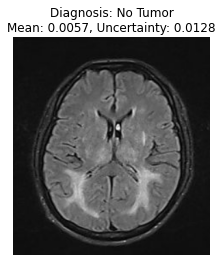

Diagnosis: No Tumor
Prediction: 0.0057, Uncertainty: 0.0128


In [48]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def predict_with_monte_carlo_dropout(image_path, model, num_samples=500):
    model.train()  # Keep dropout active during inference
    image = preprocess_image(image_path).to(device)

    predictions = []
    with torch.no_grad():
        for _ in range(num_samples):
            output = model(image)
            predictions.append(output.item())

    # Compute mean and variance
    mean_prediction = torch.mean(torch.tensor(predictions)).item()
    std_prediction = torch.std(torch.tensor(predictions)).item()

    # Determine diagnosis
    diagnosis = "Tumor" if mean_prediction > 0.5 else "No Tumor"

    # Display the image with the result
    image_to_show = Image.open(image_path)
    plt.imshow(image_to_show)
    plt.axis("off")
    plt.title(f"Diagnosis: {diagnosis}\nMean: {mean_prediction:.4f}, Uncertainty: {std_prediction:.4f}")
    plt.show(block=True)  # Ensure the image is displayed properly

    print(f"Diagnosis: {diagnosis}")
    return mean_prediction, std_prediction

# Load Model
dropout_model = MonteCarloCNN().to(device)
dropout_model.load_state_dict(torch.load("monte_carlo_trained_model.pth", map_location=device))
dropout_model.train()

# Example Usage
image_path = "C:/Users/Lenovo/Pictures/Screenshots/Screenshot 2025-02-04 172814.png"
mean_pred, uncertainty = predict_with_monte_carlo_dropout(image_path, dropout_model)
print(f"Prediction: {mean_pred:.4f}, Uncertainty: {uncertainty:.4f}")


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4732\901976385.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("monte_carlo_trained_model.

Enter the path to the image for prediction: C:\Users\Lenovo\Pictures\Screenshots\Screenshot 2025-01-26 212747.png

Prediction: Tumor
Mean Probability: 0.7111
Uncertainty (Std Dev): 0.2210


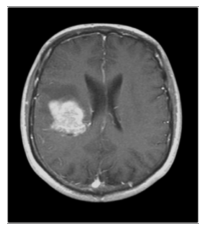

In [56]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNNModelWithDropout(torch.nn.Module):
    def __init__(self):
        super(CNNModelWithDropout, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(128 * 18 * 18, 128)
        self.fc2 = torch.nn.Linear(128, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

# Load model
model = CNNModelWithDropout().to(device)
model.load_state_dict(torch.load("monte_carlo_trained_model.pth", map_location=device))
model.eval()  # Set to evaluation mode

# Image transformation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Monte Carlo Dropout Function
def predict_with_monte_carlo_dropout(image_path, model, num_samples=100):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    model.train()  # Enable dropout for uncertainty estimation
    predictions = []

    with torch.no_grad():
        for _ in range(num_samples):
            output = model(image)
            predictions.append(output.item())

    predictions_tensor = torch.tensor(predictions)
    mean_prediction = predictions_tensor.mean().item()
    std_prediction = predictions_tensor.std().item()

    return mean_prediction, std_prediction, image_path

# Get user input
image_path = input("Enter the path to the image for prediction: ")

# Get prediction & uncertainty
mean_pred, std_pred, img_path = predict_with_monte_carlo_dropout(image_path, model, num_samples=100)

# Display the result
prediction_label = "Tumor" if mean_pred > 0.5 else "No Tumor"
print(f"\nPrediction: {prediction_label}")
print(f"Mean Probability: {mean_pred:.4f}")
print(f"Uncertainty (Std Dev): {std_pred:.4f}")

# Show image with details
image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()


In [1]:
# Apply the patch to allow nested event loops in Jupyter
nest_asyncio.apply()

# Initialize FastAPI app
app = FastAPI()

# Device configuration (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Monte Carlo CNN Model
class MonteCarloCNN(torch.nn.Module):
    def __init__(self):
        super(MonteCarloCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(128 * 18 * 18, 128)
        self.fc2 = torch.nn.Linear(128, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))  
        x = self.sigmoid(self.fc2(x))
        return x

# Load the model
model = MonteCarloCNN().to(device)
model.load_state_dict(torch.load("monte_carlo_trained_model.pth", map_location=device, weights_only=True))
model.train()  # Keep dropout active for Monte Carlo inference

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to perform Monte Carlo Dropout Prediction
def predict_with_monte_carlo_dropout(image: Image.Image, model, num_samples=100):
    image = transform(image).unsqueeze(0).to(device)
    predictions = []

    with torch.no_grad():
        for _ in range(num_samples):
            output = model(image)
            predictions.append(output.item())

    predictions_tensor = torch.tensor(predictions)
    mean_prediction = predictions_tensor.mean().item()
    std_prediction = predictions_tensor.std().item()

    return mean_prediction, std_prediction

# Define response model
class PredictionResponse(BaseModel):
    prediction: str
    mean_probability: float
    uncertainty: float

# API Endpoint for Prediction
@app.post("/predict/", response_model=PredictionResponse)
async def predict(file: UploadFile = File(...)):
    image = Image.open(io.BytesIO(await file.read())).convert("RGB")
    mean_prob, std_dev = predict_with_monte_carlo_dropout(image, model, num_samples=100)
    prediction = "Tumor" if mean_prob > 0.5 else "No Tumor"

    return {
        "prediction": prediction,
        "mean_probability": mean_prob,
        "uncertainty": std_dev
    }

# Run FastAPI app in the notebook environment
uvicorn.run(app, host="0.0.0.0", port=8000)


NameError: name 'nest_asyncio' is not defined

In [ ]:
http://127.0.0.1:8000/docs => link for fast api 